## PHYS-253 

## Homework 4

Handed out: Saturday, May 3, 2025

**Due: 4.59 pm; Monday, May 19, 2025**

## Instructions

a) You are allowed to discuss with your fellow students HOW to solve the problems. Collaboration is encouraged! But you need to hand in your INDIVIDUAL SOLUTION.  

d) List AI assistants (e.g., ChatGPT) that you worked with in arriving at a solution, or other software/tool; see detailed instructions in next cell. 

c) You can use code from previous lectures/labs - you don't neeed to reference this, it is part of the knowledge you acquired in this course.  However, if you use code from other sources, you MUST include a reference to the source.

d) Submit your Notebook (with solutions/answers) to Phys-253 site (area: ΕΡΓΑΣΙΕΣ / HW4).

### On the use of AI assistants (e.g., ChatGPT, or other Generative A.I. tools)

ChatGPT can be used as an on-line “office hours” resource to help with your learning. 
You can use ChatGPT-generated code (e.g. as inspiration if you are stuck or other reasons), however, submission of ChatGPT-generated
code without explanation or acknowledgment will earn you 0 credit. See cell below.

__________________________________________________________________________________________________________________________

## Problem 1

Train a variational autoencoder (VAE) on an dataset (*other than MNIST and Fashion MNIST*) of your choice, and use it to generate new (synthetic) data.

Hint 1: Example Notebooks will be uploaded in Week 10 or Week 11 areas; they will be discussed in class, on Monday, May 5.

Hint 2: You may use ChatGPT or other AI tools (but state what your prompt question was).

In [2]:
!pip install torch torchvision


In [1]:
# your code here
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 128
batch_size = 128
epochs = 20
lr = 1e-3

# CIFAR-10 Data Loader
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# VAE Architecture
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 64 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # 32x32
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x_enc = self.encoder(x)
        mu = self.fc_mu(x_enc)
        logvar = self.fc_logvar(x_enc)
        z = self.reparameterize(mu, logvar)
        x_dec = self.fc_decode(z)
        x_rec = self.decoder(x_dec)
        return x_rec, mu, logvar

# Loss function
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training Loop
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        recon_x, mu, logvar = model(x)
        loss = loss_fn(recon_x, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

# Generate synthetic images
model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    samples = model.decoder(model.fc_decode(z)).cpu()
    vutils.save_image(samples, 'vae_cifar10_samples.png', nrow=8)
    plt.imshow(np.transpose(vutils.make_grid(samples, nrow=8, padding=2, normalize=True), (1, 2, 0)))
    plt.title("Generated CIFAR-10 Samples")
    plt.axis('off')
    plt.show()



ModuleNotFoundError: No module named 'torch'

## Problem 2

In this problem you will make certain changes to an image dataset (in this problem, the dataset can be MNIST or Fashion MNIST) and use it to train a VAE and to generate new images. You will generate images of your choice and you will compare the quality of the images with those in the training dataset.

a) Add Gaussian noise to the training dataset, train a VAE, generate images and compare their quality to the quality of the training set (which has been contaminated by noise). Try different levels of noise. 

b) Instead of adding Gaussian noise to the training dataset, add dropout, train a VAE and generate images. How do they compare to the quality of the images generated in part a)? Try different levels of dropout.

c) Add Gaussian noise *and* dropout to the training dataset. Train a VAE generate images and compare their quality to the images generated in parts a) and b). Try different combinations of noise and dropout levels.

Hint: this peoblem will be discussed in class (Monday, May 5)

In [2]:
# your code here


## Problem 3: Morphing a fashion MNIST image
    
Train a VAE on the Fashion MNIST dataset and morph a sweater to a shoe.

Present your morphing work as an animation.

In [ ]:
# your code here


## Problem 4

This problem highligths the importance of KL divergence as a loss function. It is of particular importance to a conceptual understanding of Variational AutoEncoders (VAEs), which transform the discrete codings distribution (in latent space) of an AutoEncoder (AE) to the continuous distribution (in latent space, usually a multivariate normal distribution) from which new data (e.g. new images) can be sampled from. In VAEs, the KL divergence loss function is added to the reconstruction loss to produce new images resembling the original ones.

#### Your task:

1. Define s "target" normalized Gaussian distribution (denoted by blue color) and an "initial" normalized Gaussian distribution (red color) of your choice.

2. Write code (or consult ChatGPT on providing code) to plot distributions (starting from the "initial" distribution) that continually minimize the KL divergence from the "target" distribution.  

3. Plot all distributions in a single plot.

HINT: the following schematics can serve as a guide.

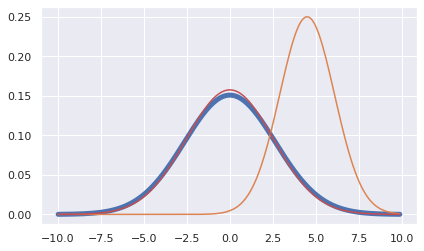

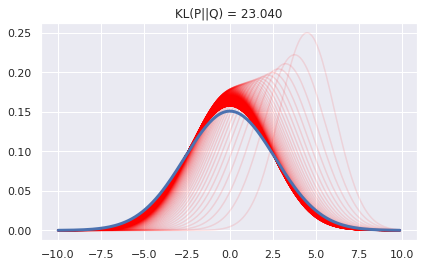

In [ ]:
# your code here


***You will get EXTRA BONUS if you present your KL work as an animation.***

## Problem 5

KL divergence is a useful metric of "probability distribution distance", widely used in deep learning. However, it is not considered as a "true" distance metric. Why? Write up short text to compare KL divergence with Wsserstein distance. You may consult Wikipedia, ChatGPT, or other sources (do not forget to mention your sources). 

In [ ]:
# your answer here (covvert this cell to Markdown so that your answer appears nicely)


__________________________________________________________________________________________________________________________